In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import datetime
from scipy import stats

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, Tuple

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data
from codelib.statistics import calculate_cornish_fisher_percentile
from codelib.portfolio_optimization.risk_budget import calculate_marginal_risks_std, calculate_risk_contributions_std
from codelib.portfolio_optimization.risk_metrics import calculate_normal_cond_value_at_risk, calculate_normal_value_at_risk
from codelib.portfolio_optimization.risk_metrics import calculate_normal_port_cond_value_at_risk, calculate_normal_port_value_at_risk



from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Exercises - Week 4

In this week we will look at a few exercises involving  risk mesures and allocating diversification benefits. 

## Problem 1: VaR and CVaR using historical simulation 

A common approach to estimate $\text{VaR}$ and $\text{CVaR}$ is simply to use or simulate from the empirical distribution function. Some are strong proponents of this method since it does not require distributional assumptions about returns, but one need to be carefull since one will often make an independence assumption and sometimes a particular model assumption may give more robust results. Blindly using the empirical distribution may limit the attention to tail events. 



__Question 1__

Obtain the equally weighted monthly return data for the five Fama-French industry portfolios ("5_Industry_Portfolios") using `pandas-datareader` since 1990-01-01  and transform the equally weighted monthly return data into log returns.


__Question 2__

Resample 10,000 vectors of returns from the monthly log returns calculated above. Use e.g. `np.random.randint`. Plot the histogram an equally weighted portfolio (linear returns). Calculate the 5\% $\text{VaR}$ and $\text{CVaR}$ of an equally weighted portfolio (linear returns) using the resampled / simulated data. 

__Question 3__

Resample 10,000 x 12 vectors of returns from the monthly log returns calculate above such to you are able to calculate the yearly portfolio return. Use e.g. `np.random.randint`. Plot the histogram of an equally weighted portfolio (yearly, linear returns). Calculate the 5\% $\text{VaR}$ and $\text{CVaR}$ of an equally weighted portfolio (linear returns) using the resampled / simulated data.

__Question 4__

Based on the portfolio returns found in question 3, use the Cornish-Fisher approximation to calculate the 5\% $\text{VaR}$ of the yearly portfolio return. Note the function `calculate_cornish_fisher_percentile` in `codelib.statistics`.

### Solution 

__Question 1__

In [2]:
# import pandas_datareader as pdr
# from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

reader = FamaFrenchReader("5_Industry_Portfolios", start=datetime.datetime(1990, 1, 1))
industry_port_daily = reader.read()

# print description
industry_port_daily['DESCR']

# get equally weighted
ind_eq_weighted = industry_port_daily[1]

# get log returns
eq_log_returns = np.log1p(ind_eq_weighted / 100.0)
eq_log_returns.head()

,Cnsmr,Manuf,HiTec,Hlth,Other
Date,,,,,
1990-01,-0.057947,-0.044056,-0.058053,-0.056253,-0.053506
1990-02,0.018036,0.029170,0.031983,0.015578,0.009158
1990-03,0.034981,0.037488,0.038259,0.043730,-0.001802
1990-04,-0.024600,-0.026857,-0.021019,-0.008637,-0.035420
1990-05,0.042485,0.046884,0.074458,0.078441,0.022055


In [3]:
eq_log_returns.shape

(390, 5)

__Question 2__

In [4]:
"""
Define resampling function 
"""

def resample(data: np.ndarray, num_sim: int, num_per: int = 1):
    
    """
    Resample input data

    Parameters
    ----------
    data: 
        Data matrix, time x assets
    num_sim: 
        Number of simulations. 
    num_per: 
        Number of periods. 

    Returns
    -------
    np.ndarray
        Ressampled data, (num_sim, num_per, number of assets)

    """
    # number of assets
    n = len(data)
    # get index for selecting data
    idx = np.random.randint(n, size=(num_sim, num_per))
    
    return data[idx, :]

In [5]:
"""
Simulate one month log-returns and transform to port. returns
"""
port_w = np.repeat(1.0/5.0, 5)
num_sim = 10000
num_per = 1

sim_log_returns = resample(eq_log_returns.values, num_sim=num_sim, num_per=num_per)
sim_lin_returns = np.exp(sim_log_returns) - 1.0
sim_port_returns = sim_lin_returns @ port_w

# note that for the one period case, you will obtain the same results by using 
# sim_port_returns = resample(ind_eq_weighted / 100.0, num_sim=num_sim, num_per=num_per)

"""
Calculate VaR and CVaR
"""

value_at_risk = np.percentile(sim_port_returns, 5)
cond_value_at_risk = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

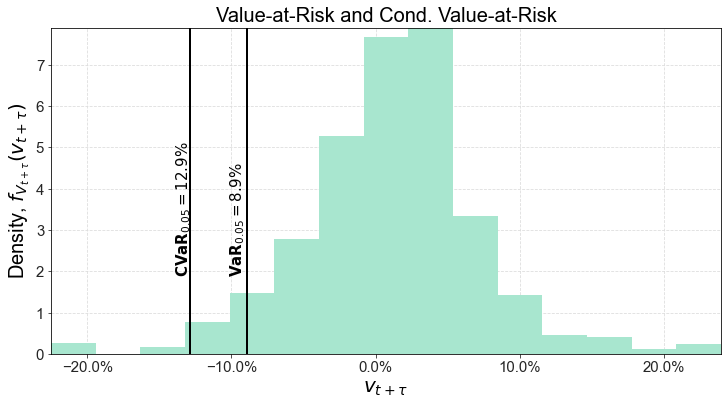

In [6]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=15);

ax.axvline(value_at_risk, ymin=0, ymax=8, color="black")
ax.axvline(cond_value_at_risk, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(-0.102, 2.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(-0.14, 2.0, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 3__

In [7]:
"""
Simulate 12 month log-returns and transform to port. returns
"""
port_w = np.repeat(1.0/5.0, 5)
num_sim = 10000
num_per = 12

sim_log_returns = resample(eq_log_returns.values, num_sim=num_sim, num_per=num_per)
sim_lin_returns = np.exp(sim_log_returns.sum(axis=1)) - 1.0
sim_port_returns = sim_lin_returns @ port_w

"""
Calculate VaR and CVaR
"""

value_at_risk = np.percentile(sim_port_returns, 5)
cond_value_at_risk = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

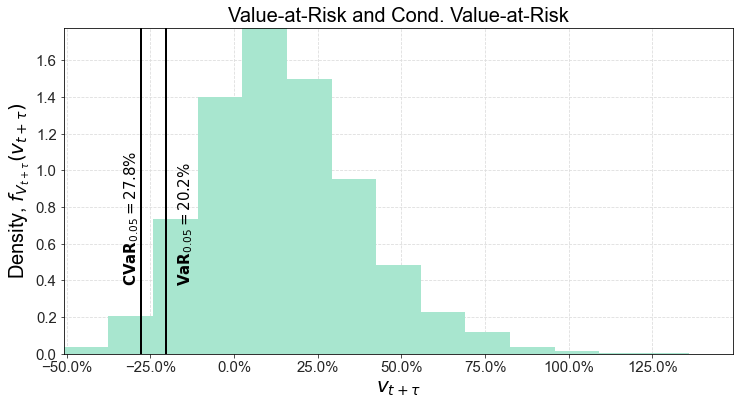

In [8]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=15);

ax.axvline(value_at_risk, ymin=0, ymax=8, color="black")
ax.axvline(cond_value_at_risk, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-value_at_risk*100)
ax.text(value_at_risk + 0.03, 0.4, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-cond_value_at_risk*100)
ax.text(cond_value_at_risk - 0.055, 0.4, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 4__

In [9]:
est_mean = np.mean(sim_port_returns)
est_sigma = np.std(sim_port_returns)
est_skew = stats.skew(sim_port_returns)
est_kurt = stats.kurtosis(sim_port_returns)

cf_var = calculate_cornish_fisher_percentile(0.05, est_mean, est_sigma, est_skew, est_kurt)
cf_var

-0.1997991402997076

## Problem 2: Maximum drawdown

[Drawdown](https://en.wikipedia.org/wiki/Drawdown_(economics)) is a measure of the decline from a historical peak. The drawdown at time $T$ from the starting time $0$ can be defined as (we are using linear returns, but it could also be the loss itself)

$$
DD(T) = \min \left[ \frac{P_T - \max_{t \in (0, T)} P_t}{\max_{t \in (0, T)} P_t}, 0\right]
$$

The maximum drawdown (the most negative return) is 

$$
MDD(T) = \min_{t \in (0, T)} \left[ \frac{P_T - \max_{t \in (0, T)} P_t}{\max_{t \in (0, T)} P_t}, 0\right]
$$

__Question 1__

Implement two functions that calculate respectively the drawdown and maximum drawdown. Let the drawdown function return the drawdown at each point in time. 

__Question 2__

Plot the drawdown of SP500 since 1990-01-01 (hint: use `pandas-datareader`, ticker: '^GSPC', data_source: 'yahoo'). What is the maximum draw down?

### Solution 

__Question 1__

In [10]:
def drawdown(index: np.ndarray):
    
    """
    Calculates the running draw down 
    
    Parameters
    ----------
    index: 
        Values of e.g. at equity index
        
    Returns
    -------
    Tuple(np.ndarray, np.ndarray)
        Drawdown, index of running maximum
    
    """
    
    indexmax = index.cummax()
    drawdowns = (index - indexmax) / indexmax
    
    return drawdowns, indexmax
    
def maxdrawdown(index: np.ndarray):

    """
    Calculates maximum draw down 
    
    Parameters
    ----------
    index: 
        Values of e.g. at equity index
        
    Returns
    -------
    float
        Maximum drawdown
    
    """
    
    return drawdown(index)[0].min()
        

__Question 2__

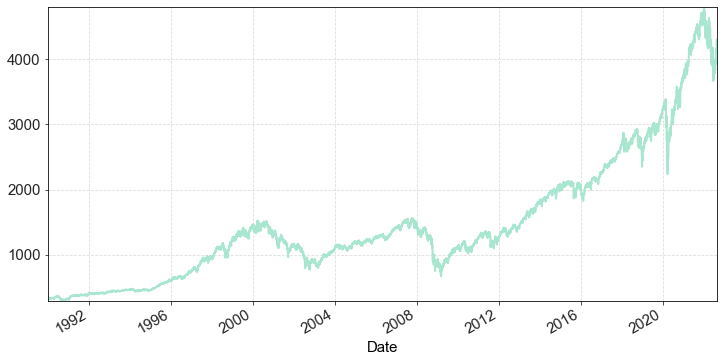

In [11]:
sp500_adjclose = DataReader('^GSPC', 'yahoo', start=datetime.date(1990, 1, 1))['Adj Close']
sp500_adjclose.plot(figsize=(12,6));

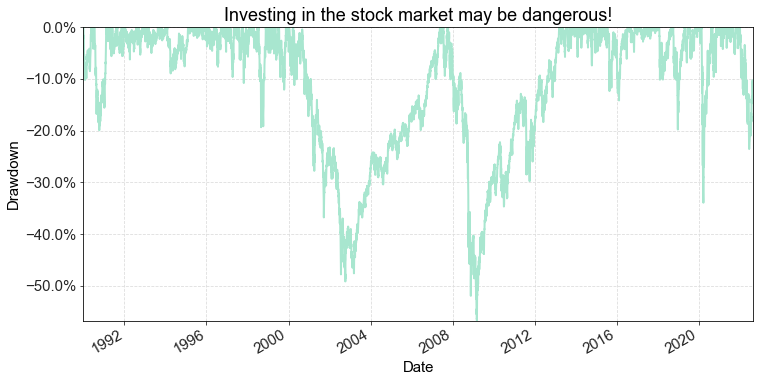

In [12]:
"""
Plotting drawdown plot
"""

ax = drawdown(sp500_adjclose)[0].plot(figsize=(12, 6));

ax.set_title('Investing in the stock market may be dangerous!')
ax.set_ylabel('Drawdown')

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.yaxis.set_major_formatter(xticks)

In [13]:
maxdrawdown(sp500_adjclose)

-0.5677538774277282

## Problem 3: Portfolio diversification

In this problem, we will learn how to perform risk decompostion if we for simplicity assume that returns follow a normal distribution. 

Consider the 

## Problem 4: Allocating diversification benefits for VaR and CVaR

In this problem, we will learn how to perform risk decompostion if we for simplicity assume that the linear returns follow a normal distribution. 

As in problem 3, assume that 

$$
\boldsymbol{\mu}  = \begin{bmatrix} 0.02 \\ 0.04 \\ 0.08 \end{bmatrix}, \; \mathbf{v} = \begin{bmatrix} 0.075 \\ 0.15 \\ 0.3 \end{bmatrix}, \; \textbf{Corr} = \begin{bmatrix} 1.0 & 0.2 & 0.1 \\
                     0.2 & 1.0 & 0.4 \\
                     0.1 & 0.4 & 1.0 \end{bmatrix}
$$

and add the assumption that the returns follow a multivariate normal distribution

$$
\mathbf{R} \sim \text{MVN}(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

where $\boldsymbol{\Sigma}$ is the covariance matrix. We know that we can write the portfolio mean as ($\mathbf{w}$ is the portfolio weights)

$$
\mu_P(\mathbf{w}) = \mathbf{w}^\top \boldsymbol{\mu}
$$

and the standard deviation as 

$$
\sigma_P(\mathbf{w}) = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
$$

such that the portfolio return follows a normal distribution

$$
R_P = \mathbf{w}^\top \mathbf{R} \sim N(\mu_P(\mathbf{w}), \sigma_P^2(\mathbf{w}))
$$


Furthermore, consider an equally weighted portfolio. 

__Question 1__


Given our understanding of the normal distribution, we can calculate the VaR as 

$$
\text{VaR}_{\alpha} (\mathbf{w}) = - \mu_P(\mathbf{w}) + \sigma_P(\mathbf{w}) \Phi^{-1}(1 - \alpha)
$$

where $\phi()$ and $\Phi^{-1}()$ denote the standard normal pdf and quantile function respectively. 

The CVaR is given by

$$
\text{CVaR}_{\alpha} = -\mu_P + \sigma_P \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha}
$$ 

Calculate VaR(5%) and CVaR(5%) of an equally weighted portfolio using the normal assumption. 


__Question 2__

We can decompose the VaR using 

$$
\text{VaR}_{\alpha}(\mathbf{w}) = \sum_{i=1}^N w_i \frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i}
$$


Find the marginal risk (use e.g. the chain-rule)

$$
\frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i},
$$

implement a function calculating the marginal risk and risk contribution, and calculate the values for an equally weighted portfolio. 

Is the VaR equal the sum of the risk contributions?

__Question 3__

We can decompose the CVaR using 

$$
\text{CVaR}_{\alpha}(\mathbf{w}) = \sum_{i=1}^N w_i \frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i}
$$

Find the marginal risk

$$
\frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i},
$$

implement a function calculating the marginal risk and risk contribution, and calculate the values for an equally weighted portfolio. 

Is the CVaR equal the sum of the risk contributions?

### Solution

__Question 1__

We simply define functions that implement the above definitions. See `codelib.portfolio_optimization.risk_metrices` for the definition of the functions. 

In [14]:
mu = np.array([0.02, 0.04, 0.08])
vols = np.array([0.075, 0.15, 0.3])
corr_mat = np.array([[1.0, 0.2, 0.1],
                     [0.2, 1.0, 0.4],
                     [0.1, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

weights = np.repeat(1.0 / 3.0, 3)

In [15]:
-calculate_normal_port_value_at_risk(weights, mu, cov_mat)

0.17477852995199877

In [16]:
-calculate_normal_port_cond_value_at_risk(weights, mu, cov_mat)

0.23103454378869823

__Question 2__

First, we need to find 

$$
\frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i} 
$$

We can simply use the chain-rule and that (what we have seen at the lectures)

$$
\nabla \sigma_P(\mathbf{w}) = \frac{d \sigma_P(\mathbf{w}) }{d \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}\frac{\partial \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}{\partial \mathbf{w}} = \frac{1}{2\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}} 2 \boldsymbol{\Sigma} \mathbf{w} = \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$


We find 

$$
\nabla \text{VaR}_{\alpha} = -\boldsymbol{\mu} +  \Phi^{-1}(1 - \alpha) \nabla \sigma_P(\mathbf{w}) = -\boldsymbol{\mu} +  \Phi^{-1}(1 - \alpha)  \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

Thus, 

$$
\frac{\partial \text{VaR}_{\alpha}(\mathbf{w})}{\partial w_i} = -\mu_i +  \Phi^{-1}(1 - \alpha)  \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

In [17]:
def calculate_marginal_risks_normal_var(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr_std = calculate_marginal_risks_std(weights, cov_mat)
    
    mr_var = -mu + stats.norm.ppf(1.0 - alpha) * mr_std
    
    return mr_var

In [18]:
def calculate_risk_contributions_normal_var(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_normal_var(weights, mu, cov_mat, alpha=alpha)
    
    return weights * mr

In [19]:
mr_var = calculate_marginal_risks_normal_var(weights, mu, cov_mat, alpha=0.05)
mr_var

array([0.02123462, 0.13410174, 0.36899923])

In [20]:
mrc_var = calculate_risk_contributions_normal_var(weights, mu, cov_mat, alpha=0.05)
mrc_var

array([0.00707821, 0.04470058, 0.12299974])

In [21]:
mrc_var.sum()

0.17477852995199866

We see that the sum of marginal risk contributions are equal to VaR.

__Question 3__

We need to find 

$$
\frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i} 
$$

We follow the same approach as before

$$
\nabla \text{CVaR}_{\alpha} = -\boldsymbol{\mu} +  \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha} \nabla \sigma_P(\mathbf{w}) = -\boldsymbol{\mu} +  \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha} \frac{\boldsymbol{\Sigma} \mathbf{w} }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

Thus, 

$$
\frac{\partial \text{CVaR}_{\alpha}(\mathbf{w})}{\partial w_i} = -\mu_i +  \frac{\phi\left(\Phi^{-1}(\alpha) \right)}{\alpha} \frac{(\boldsymbol{\Sigma} \mathbf{w})_i }{\sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}}
$$

In [22]:
def calculate_marginal_risks_normal_cvar(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Cond. Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr_std = calculate_marginal_risks_std(weights, cov_mat)
    
    qnorm = stats.norm.ppf(alpha)
    
    mr_cvar = -mu + stats.norm.pdf(qnorm) / alpha * mr_std
    
    return mr_cvar

In [23]:
def calculate_risk_contributions_normal_cvar(weights: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, alpha: float = 0.05) -> np.ndarray:
    """
    Function that calculates marginal risk using Cond. Value-at-Risk as risk measure.
    It is assumed that returns follow a normal distribution.

    Parameters
    ----------
    weights:
        Portfolio weights
    mu:
        Vector of expected returns
    cov_mat:
        Covariance matrix
    alpha:
        Confidence level

    Returns
    -------
    np.ndarray
        Marginal risks
    """

    mr = calculate_marginal_risks_normal_cvar(weights, mu, cov_mat, alpha=alpha)
    
    return weights * mr

In [24]:
mr_cvar = calculate_marginal_risks_normal_cvar(weights, mu, cov_mat, alpha=0.05)
mr_cvar

array([0.03170988, 0.17833061, 0.48306314])

In [25]:
mrc_cvar = calculate_risk_contributions_normal_cvar(weights, mu, cov_mat, alpha=0.05)
mrc_cvar

array([0.01056996, 0.05944354, 0.16102105])

In [26]:
mrc_cvar.sum()

0.2310345437886982

We see that the sum of marginal risk contributions are equal to CVaR.

It is important to note that given the Gaussian assumption, the relative risk contribution is determined primarily by the risk contribution obtained using standard devation as a risk measure (assuming $\boldsymbol{\mu}$ close to zero). Thus, one would expect to obtain similar results using either risk measure. 

## Problem 5: Scenario based risk measures

In many applications, we use scenerios either historical or Monte Carlo to calculate risk measures of a portfolio. In this exercise, we will see how with can allocate risk when a simulation based approach is taken. 

Again, we consider ...


__Question 1__


__Question 2__


__Question 3__


__Question 4__


### Solution 

__Question 1__

In [27]:
mu = np.array([0.02, 0.04, 0.08])
vols = np.array([0.075, 0.15, 0.3])
corr_mat = np.array([[1.0, 0.2, 0.1],
                     [0.2, 1.0, 0.4],
                     [0.1, 0.4, 1.0]])

cov_mat = np.outer(vols, vols) * corr_mat
cov_mat

# port. weights
weights = np.repeat(1.0 / 3.0, 3)

# number of simulations 
num_sim = 1000

In [28]:
# simulate asset returns
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=num_sim)

# calculate portfolio returns for each simulation
sim_port_returns = sim_returns @ weights 



In [29]:
# calculate VaR and CVaR
sim_var = np.percentile(sim_port_returns, 5)
sim_cvar = np.mean(sim_port_returns[sim_port_returns <= value_at_risk])

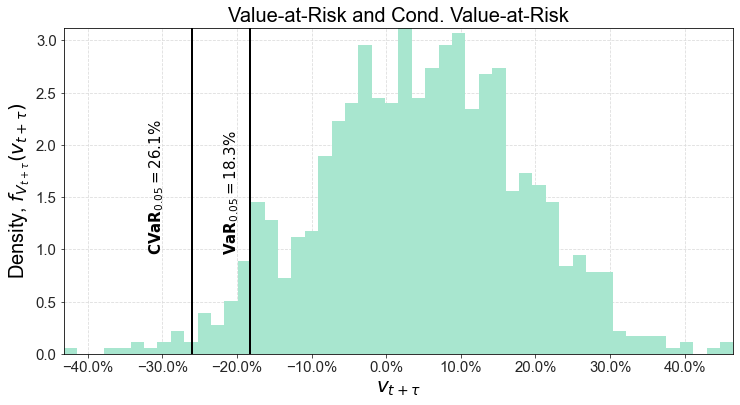

In [30]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(sim_port_returns, density=True, bins=50);

ax.axvline(sim_var, ymin=0, ymax=8, color="black")
ax.axvline(sim_cvar, ymin=0, ymax=8, color="black")
ax.set_title("Value-at-Risk and Cond. Value-at-Risk", size=20)
ax.set_xlabel('$v_{t + \\tau}$', size=20)
ax.set_ylabel('Density, $f_{V_{t + \\tau}}(v_{t + \\tau})$', size=20);

# add text
text_to_add =  "$\mathbf{VaR}_{0.05}" + " = {:,.1f}\%$".format(-sim_var*100)
ax.text(-0.22, 1.0, text_to_add, rotation=90);

text_to_add_2 =  "$\mathbf{CVaR}_{0.05}" + " = {:,.1f}\%$".format(-sim_cvar*100)
ax.text(-0.32, 1.0, text_to_add_2,rotation=90);

# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

__Question 2__

In [68]:
num_iter = 100000
num_sim = 1000

In [69]:
# simulate asset returns
sim_returns = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_iter))

# calculate portfolio returns for each simulation
sim_port_returns = sim_returns @ weights 

MemoryError: Unable to allocate 4.47 GiB for an array with shape (200000000, 3) and data type float64

In [ ]:
# Calculate VaR for all num_iter samples of num_sim observations
sim_var_all = np.percentile(sim_port_returns, 5, axis=0)

In [ ]:
# shape of numpy array with all VaR estimates
sim_var_all.shape

In [ ]:
"""
Plot histogram 
"""

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(-sim_var_all, density=True, bins=100);

ax.set_title("Value-at-Risk", size=20)
ax.set_xlabel('VaR(5%)', size=20)
ax.set_ylabel('Density', size=20);


# x-axis a percent
xticks = mtick.PercentFormatter(xmax=1.0, decimals=1)
ax.xaxis.set_major_formatter(xticks)

In [ ]:
# calculate the percentiles
np.percentile(-sim_var_all, [2.5, 97.5])

In [ ]:
alpha = 0.95
exact_var = -calculate_normal_port_value_at_risk(weights, mu, cov_mat)
# epsilon
epsilon = np.sqrt(np.log(2.0 / alpha) / (2 * num_sim))

# lower and upper bounds 
lower = np.clip(exact_var - epsilon, 0, 1)
upper = np.clip(exact_var + epsilon, 0, 1)

In [ ]:
lower

In [ ]:
upper